In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy import stats
import matplotlib.ticker as ticker
import os
from reload_recursive import reload_recursive

from mri_data import file_manager as fm
import helpers

In [17]:
reload_recursive(helpers)

In [18]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data"

In [19]:
df = pd.read_csv(data_dir / "t1_data_full.csv")
df = df.set_index("subid")

In [20]:
df = helpers.set_dz_type5(df)
df = helpers.set_dz_type3(df)
df = helpers.fix_edss(df)
df = helpers.clean_df(df)

In [21]:
keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dz_type3",
    "dz_type5",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "DMT_score",
    "DMT_hx_all",
    "flair_contrast",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "tiv",
    "pineal_volume",
]

df = df.loc[:, keep_cols]
df = pd.concat((df, pd.get_dummies(df["sex"])), axis=1)

(array([  6.,  23.,  61., 114., 111.,  89.,  40.,  18.,  11.,  19.]),
 array([-0.73551597, -0.49787074, -0.26022551, -0.02258027,  0.21506496,
         0.45271019,  0.69035542,  0.92800065,  1.16564588,  1.40329112,
         1.64093635]),
 <BarContainer object of 10 artists>)

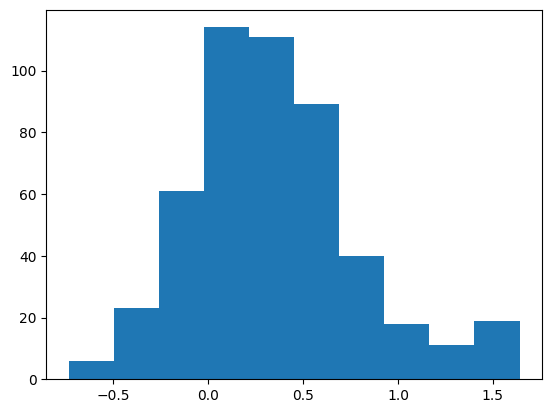

In [22]:
df.loc[:, "lesion_vol_logtrans"] = np.log(df["lesion_vol_cubic"])
plt.hist(df["lesion_vol_logtrans"])

(array([ 12.,   0.,   2.,  71., 180.,  54.,  38.,  19.,  56.,  10.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

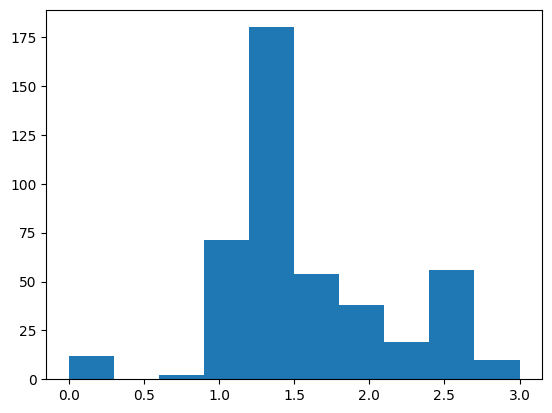

In [23]:
df.loc[:, "edss_sqrt"] = np.sqrt(df["EDSS"].astype("float"))
plt.hist(df["edss_sqrt"])

(array([ 8., 35., 49., 58., 53., 55., 51., 43., 28., 23.]),
 array([0.2236068 , 0.51684079, 0.81007479, 1.10330879, 1.39654279,
        1.68977678, 1.98301078, 2.27624478, 2.56947877, 2.86271277,
        3.15594677]),
 <BarContainer object of 10 artists>)

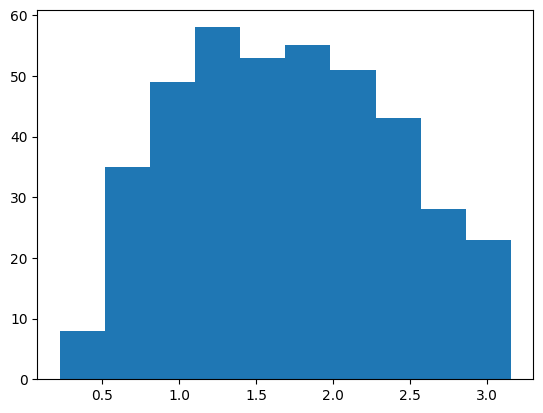

In [24]:
df.loc[:, "msss_sqrt"] = np.sqrt(df["MSSS"])
plt.hist(df["msss_sqrt"])

(array([10., 28., 65., 60., 69., 60., 53., 39., 32., 24.]),
 array([0.37416574, 0.65155069, 0.92893564, 1.20632059, 1.48370554,
        1.76109049, 2.03847544, 2.3158604 , 2.59324535, 2.8706303 ,
        3.14801525]),
 <BarContainer object of 10 artists>)

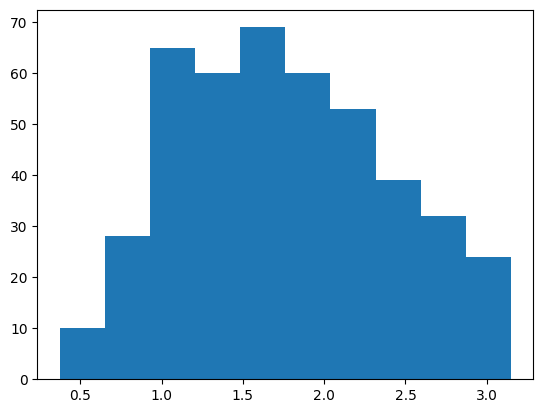

In [25]:
df.loc[:, "armss_sqrt"] = np.sqrt(df["ARMSS"])
plt.hist(df["armss_sqrt"])

In [26]:
vars = [
    "age",
    "Female",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "edss_sqrt",
    "msss_sqrt",
    "armss_sqrt",
    "DMT_score",
    "DMT_hx_all",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "tiv",
    "pineal_volume",
]

In [27]:
data = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
data = data[vars].astype("float")
data = data.dropna()
data_z = data[vars].apply(stats.zscore)

In [29]:
outcome_model = sm.OLS.from_formula(
    "pineal_volume ~  lesion_vol_cubic + age + tiv + Female", data=data
)

res = outcome_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          pineal_volume   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.834
Date:                Sun, 16 Feb 2025   Prob (F-statistic):              0.122
Time:                        21:36:21   Log-Likelihood:                -2199.9
No. Observations:                 376   AIC:                             4410.
Df Residuals:                     371   BIC:                             4430.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          172.5464     70.538  